In [1]:
import cell2cell as c2c

import numpy as np
import pandas as pd

import scipy.stats as st
from statsmodels.stats.multitest import multipletests

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
data_folder = '../data/'

In [4]:
import os

output_folder = '../results/LR-Location-vs-CC-Distance/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [5]:
dist = pd.read_csv(data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv', index_col=0)

In [6]:
ann_lr_pairs = pd.read_excel(data_folder + '/PPI-Networks/Celegans-Curated-LR-pairs.xlsx')

In [7]:
ga_lr_pairs = pd.read_csv(data_folder + '/PPI-Networks/Celegans-GA-BrayCurtis-Selected-LR-pairs.csv')

In [8]:
ga_lr_pairs = ga_lr_pairs.merge(ann_lr_pairs)
ga_lr_pairs['IntName'] = ga_lr_pairs.apply(lambda x: x['Ligand_symbol'] + ' / ' + x['Receptor_symbol'], axis=1)

In [9]:
ccc_matrix = pd.read_csv('../results/CCI-GA-BrayCurtis-LRs/CCC-Celegans-SelectedLR.csv', index_col=0)

# Visualization

In [10]:
sorted_lrs = list(ga_lr_pairs.sort_values(by=['Location_type', 'IntName'])['IntName'].values)

In [11]:
lr_colors = c2c.plotting.aesthetics.map_colors_to_metadata(ga_lr_pairs, 
                                                           sample_col='IntName', group_col='Location_type',
                                                           cmap='viridis',
                                                          )

In [12]:
def define_range(x):
    if x < 5.6:
        return 'Short-Range Distance'
    elif x < 70.:
        return 'Mid-Range Distance'
    else:
        return 'Long-Range Distance'

In [13]:
pairs = c2c.core.interaction_space.generate_pairs(dist.columns, cci_type='undirected')
cell_int = [p[0] + ';' + p[1] for p in pairs]

In [14]:
distances = pd.melt(dist.reset_index(), id_vars='index')
distances.columns = ['Cell1', 'Cell2', 'Distance']

# Exclude autocrine interactions
# distances = distances.loc[distances['Distance'] > 0]

distances['Range'] = distances['Distance'].apply(define_range)
distances['Interaction'] = distances.apply(lambda row: row['Cell1'] + ';' + row['Cell2'], axis=1)
distances = distances.loc[distances['Interaction'].isin(cell_int)].reset_index(drop=True)

In [15]:
sorted_cells = list(distances.sort_values(by=['Distance', 'Interaction'])['Interaction'].values)

In [16]:
sorted_cells_r = [';'.join(p.split(';')[::-1]) for p in sorted_cells]

In [17]:
def map_color(label):
    if label == 'Short-Range Distance':
        return (255/255, 153/255, 153/255, 1.) #'red'
    if label == 'Mid-Range Distance':
        return (255/255, 219/255, 152/255, 1.) #'orange'
    if label == 'Long-Range Distance':
        return (153/255, 153/255, 255/255, 1.) #'blue'
    else:
        return 'purple'

In [18]:
distances['Color'] = distances['Range'].map(map_color)
dist_colors = distances.set_index('Interaction')['Color']

## Directed Communication

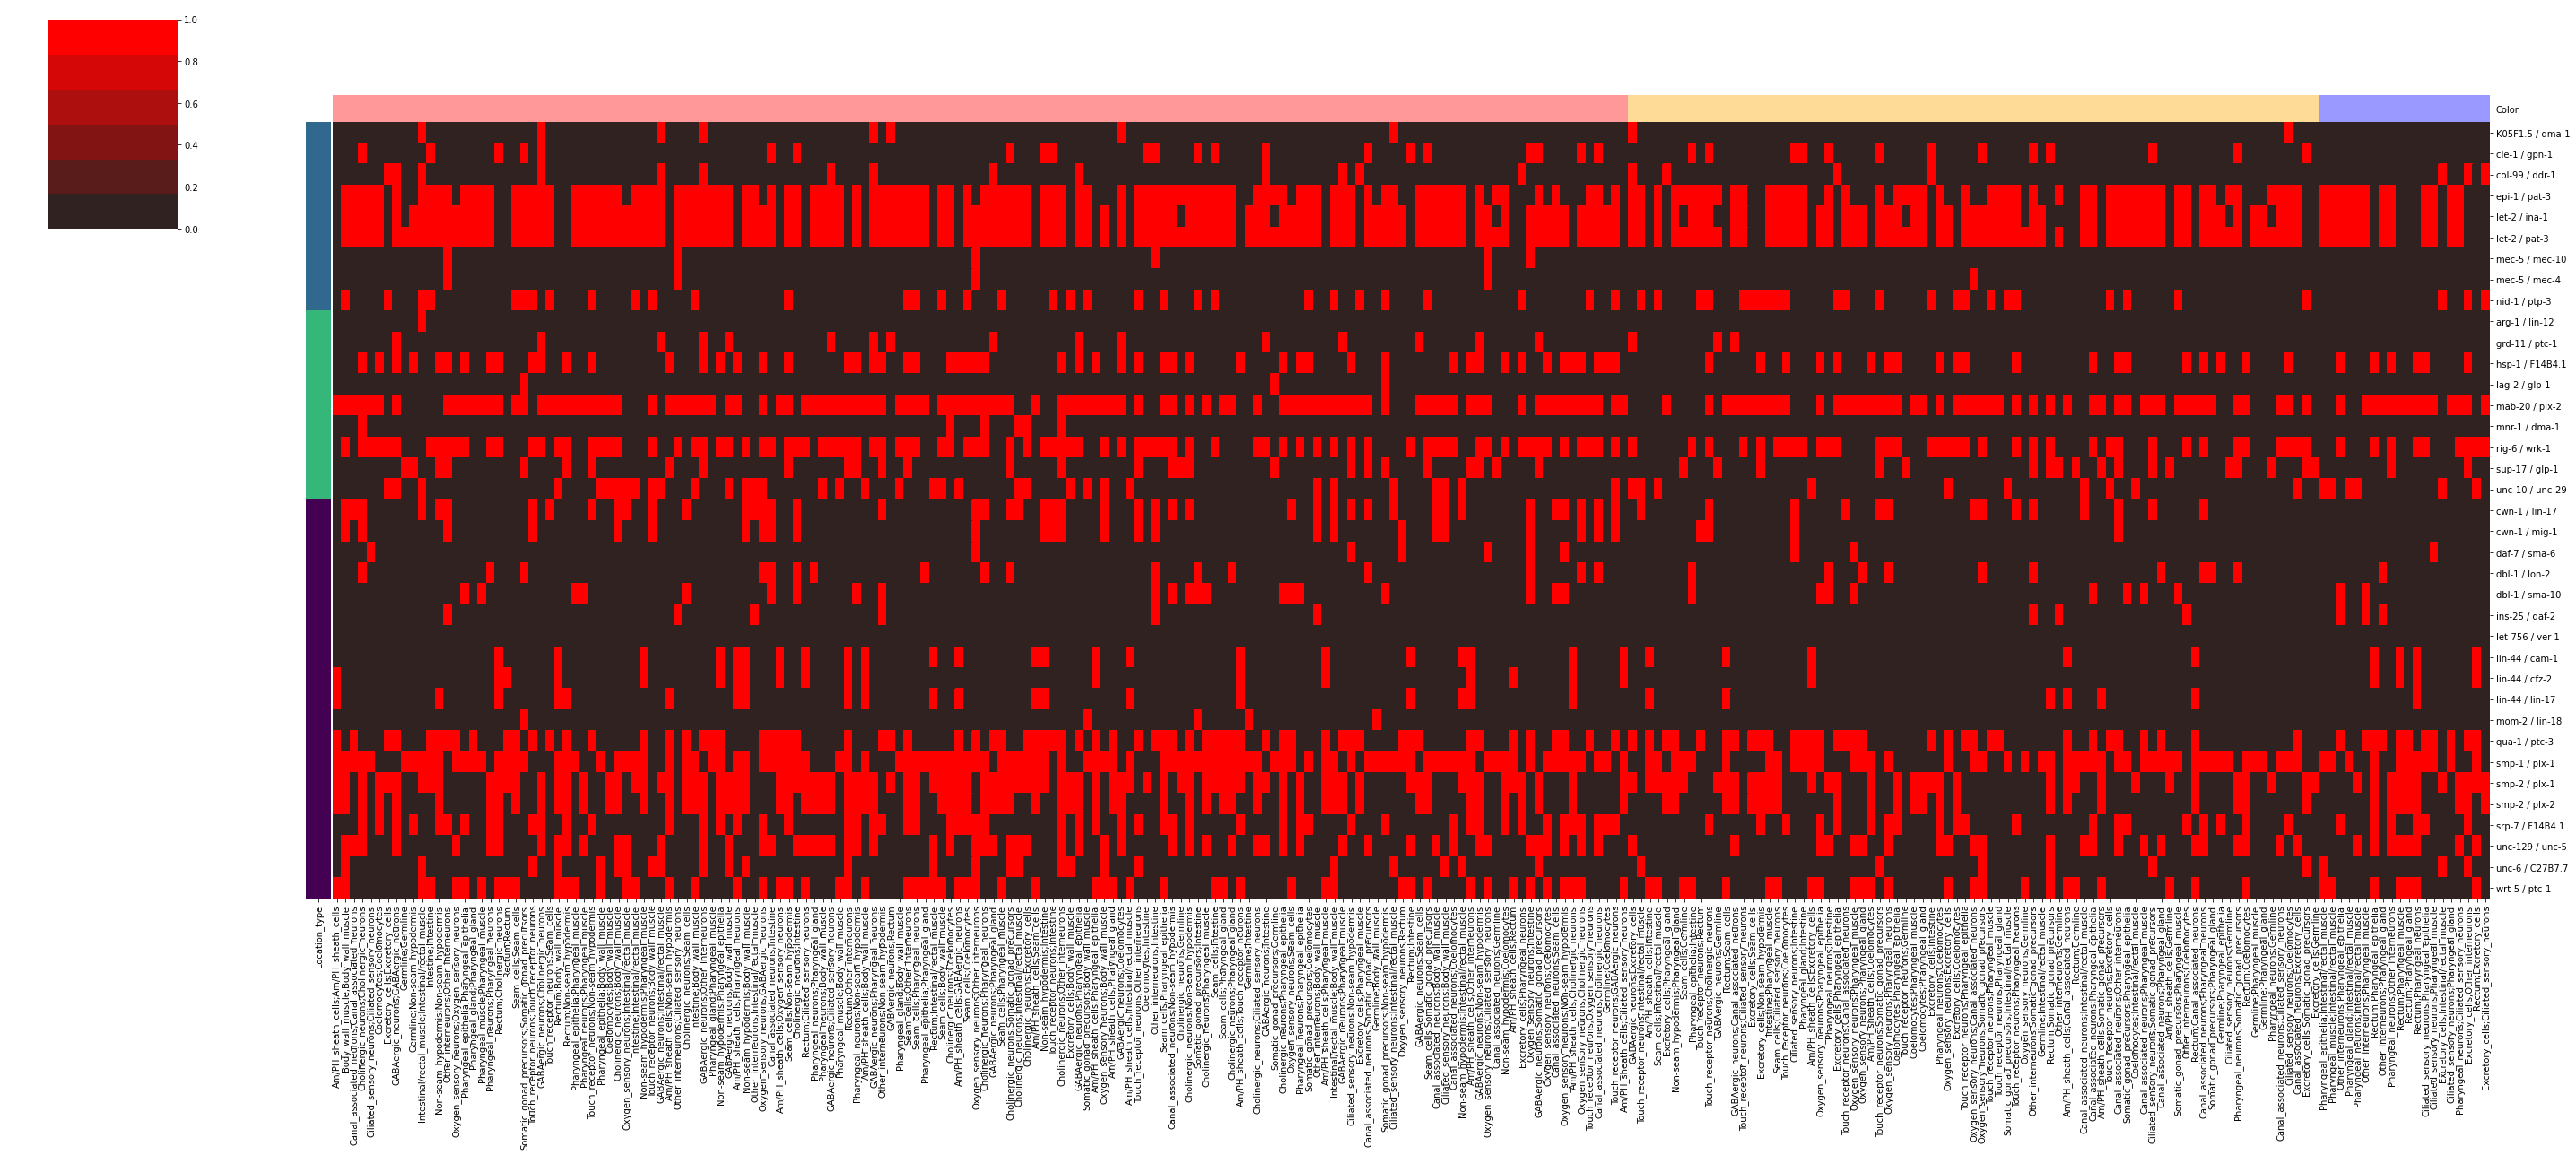

In [19]:
cm = sns.clustermap(ccc_matrix.loc[sorted_lrs, sorted_cells],
                    col_cluster=False,
                    row_cluster=False,
                    col_colors=dist_colors,
                    row_colors=lr_colors,
                    cmap=sns.dark_palette('red'),
                    figsize=(40, 18),
                    yticklabels=1,
                    xticklabels=1,
                    dendrogram_ratio=0.1
                   )

# Resize clustermap and dendrograms
hm = cm.ax_heatmap.get_position()
w_mult = 1.0
h_mult = 1.0
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width * w_mult, hm.height])

row = cm.ax_row_colors.get_position()
row_d_mult = 0.33
cm.ax_row_colors.set_position(
    [row.x0 + row.width * (1 - row_d_mult), row.y0, row.width * row_d_mult, row.height * h_mult])

col = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([col.x0, col.y0, col.width * w_mult, col.height * 1.0])

## Undirected communication

In [20]:
ccc1 = ccc_matrix.loc[sorted_lrs, sorted_cells]
ccc2 = ccc_matrix.loc[sorted_lrs, sorted_cells_r]
ccc2.columns = sorted_cells
ccc3 = (ccc1 + ccc2).gt(0).astype(int)

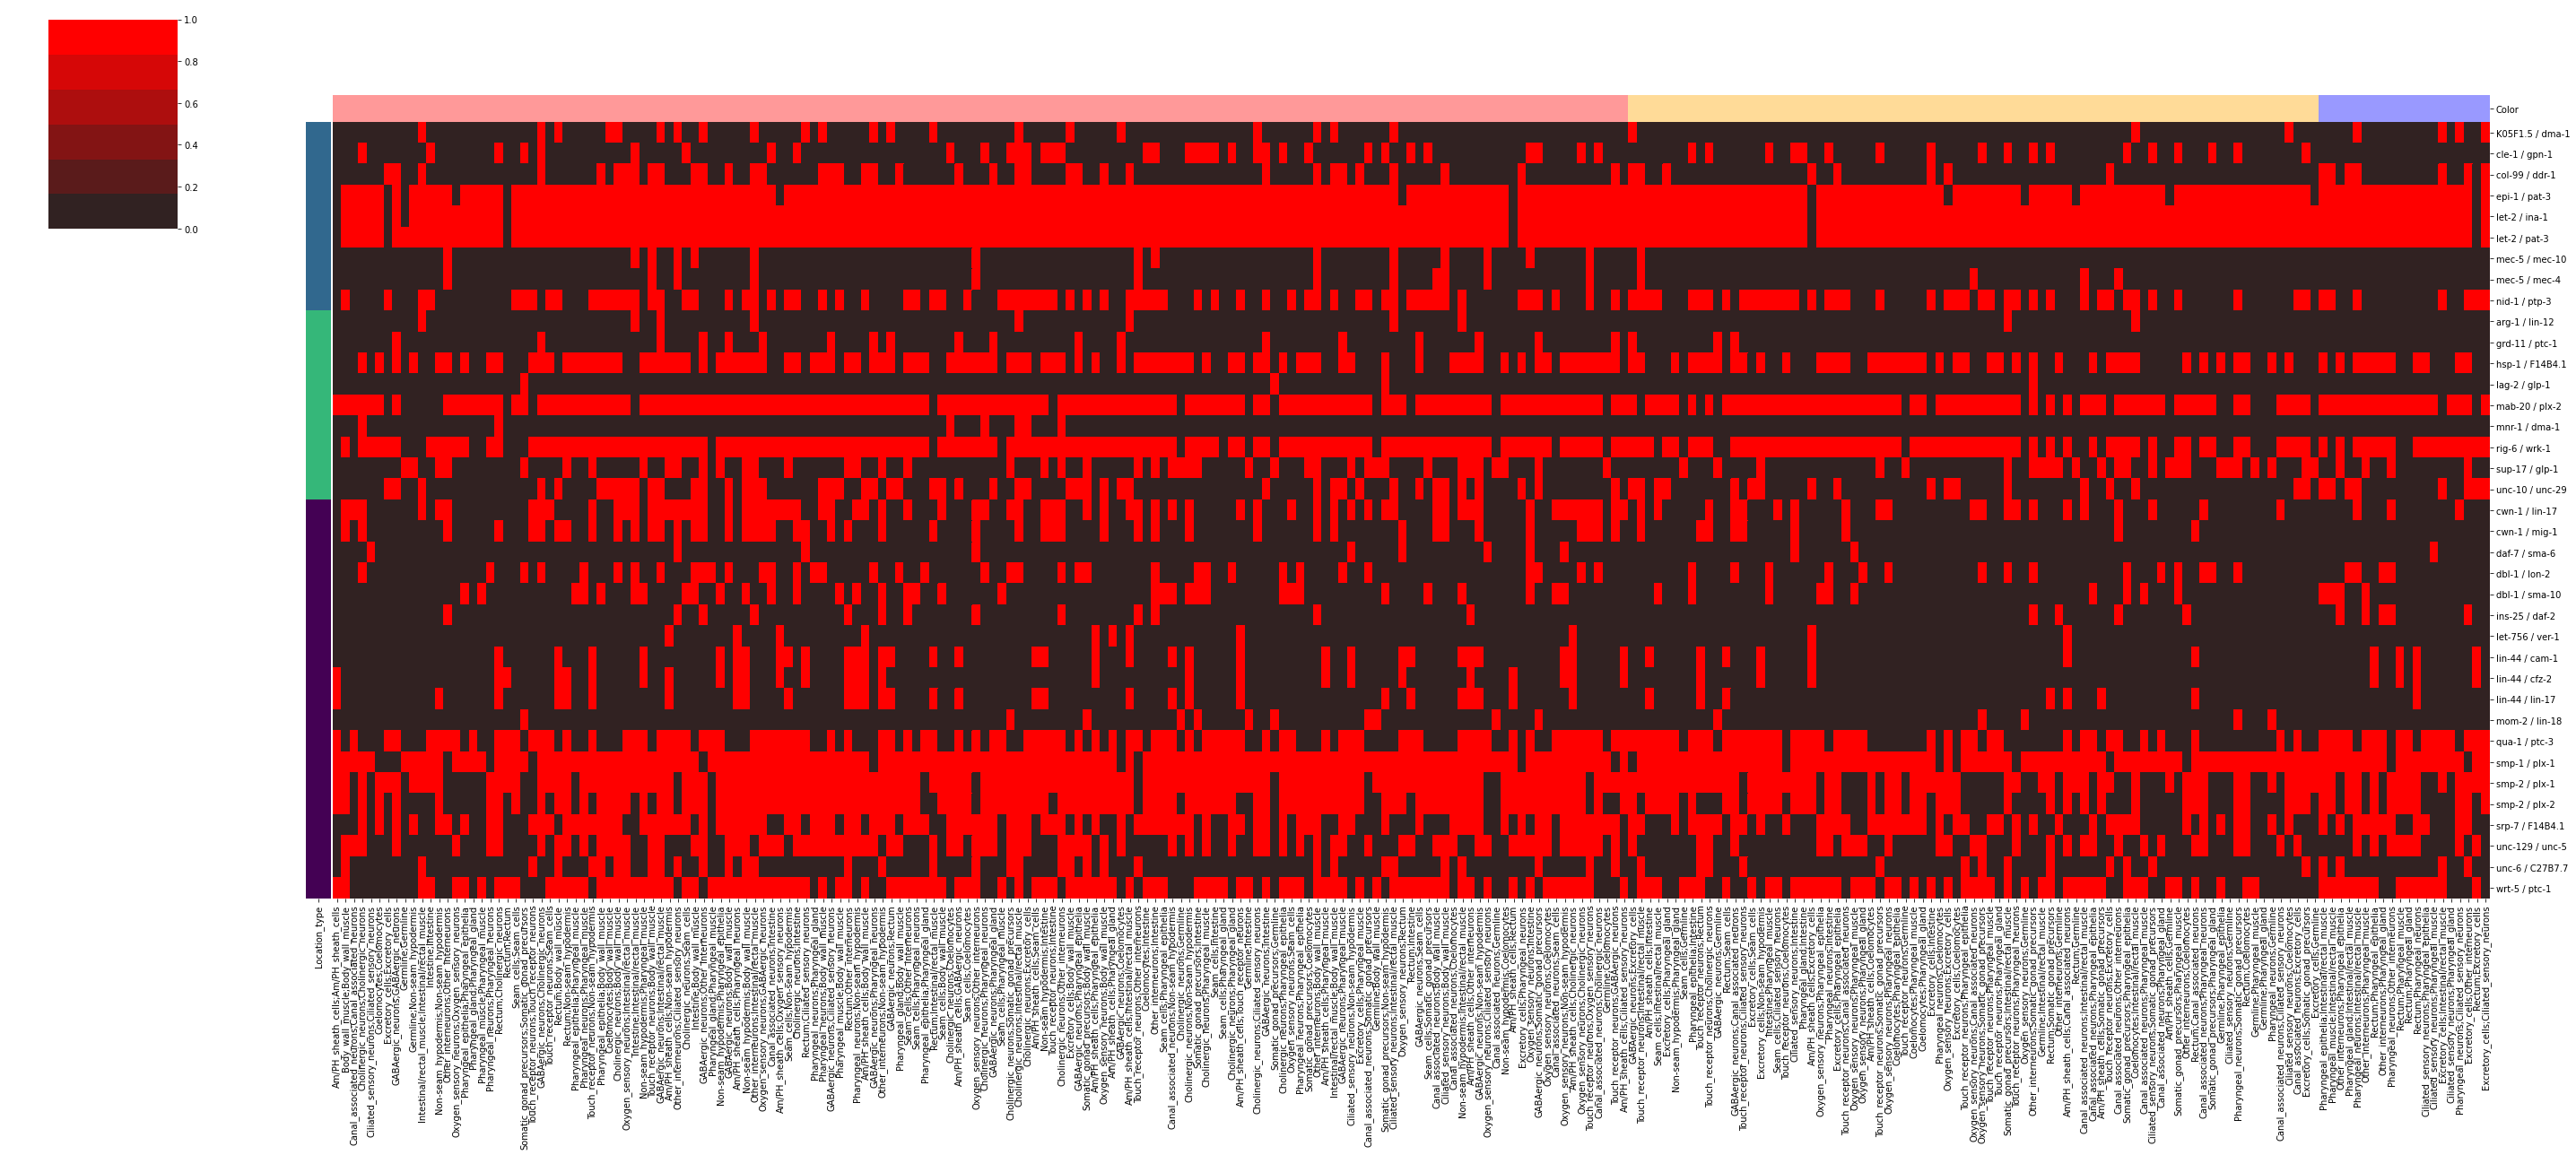

In [21]:
cm = sns.clustermap(ccc3,
                    col_cluster=False,
                    row_cluster=False,
                    col_colors=dist_colors,
                    row_colors=lr_colors,
                    cmap=sns.dark_palette('red'),
                    figsize=(40, 18),
                    yticklabels=1,
                    xticklabels=1,
                    dendrogram_ratio=0.1,
                   )

# Resize clustermap and dendrograms
hm = cm.ax_heatmap.get_position()
w_mult = 1.0
h_mult = 1.0
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width * w_mult, hm.height])

row = cm.ax_row_colors.get_position()
row_d_mult = 0.33
cm.ax_row_colors.set_position(
    [row.x0 + row.width * (1 - row_d_mult), row.y0, row.width * row_d_mult, row.height * h_mult])

col = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([col.x0, col.y0, col.width * w_mult, col.height * 1.0])

plt.savefig(output_folder + '/CCC-by-Distance&LR-Location-type.svg',
            dpi=300,
            bbox_inches='tight')

In [22]:
records = []

total = np.prod(ccc3.shape)
pos_total = ccc3.sum().sum()

for lr_type, df in ga_lr_pairs.groupby('Location_type'):
    lr_names = df['IntName'].values.tolist()
    print(lr_type, len(lr_names))
    
    type_N = np.prod(ccc3.loc[lr_names, :].shape)
    type_pos_N = ccc3.loc[lr_names, :].sum().sum()
    
    for d_range, df2 in distances.groupby('Range'):
        cc_names = df2['Interaction'].values.tolist()
        
        range_N = np.prod(ccc3.loc[:, cc_names].shape)
        range_pos_N = ccc3.loc[:, cc_names].sum().sum()
        
        ccc_tmp = ccc3.loc[lr_names, cc_names]
        
        n = np.prod(ccc_tmp.shape)
        pos_n = ccc_tmp.sum().sum()

        cont = pd.DataFrame({'Range' :  [pos_n, range_pos_N-pos_n],
                             'Other-Range' : [type_pos_N-pos_n, pos_total-type_pos_N-range_pos_N+pos_n]
                            },
                            index=pd.Index(['LR-Type', 'Other-LR-Type']))
              
        odds, p = st.fisher_exact(table=cont.to_numpy(), alternative='two-sided')

        record = (lr_type, d_range, odds, p)    
        
        records.append(record)
        
lr_fisher_df = pd.DataFrame.from_records(records, columns=['Location_type', 'Range', 'Odds',
                                                           'P-value'
                                                          ])

ECM-component 9
Membrane-bound 9
Secreted 19


In [23]:
lr_fisher_df.sort_values(['Location_type', 'Range'], ascending=[True, False])

,Location_type,Range,Odds,P-value
2,ECM-component,Short-Range Distance,0.835509,0.022917
1,ECM-component,Mid-Range Distance,1.229469,0.013454
0,ECM-component,Long-Range Distance,0.990800,1.000000
5,Membrane-bound,Short-Range Distance,0.965858,0.698512
4,Membrane-bound,Mid-Range Distance,1.037576,0.679389
3,Membrane-bound,Long-Range Distance,1.007779,0.937760
8,Secreted,Short-Range Distance,1.192335,0.014865
7,Secreted,Mid-Range Distance,0.817353,0.009272
6,Secreted,Long-Range Distance,1.002328,1.000000


In [24]:
lr_fisher_df.sort_values(['Location_type', 'Range'], ascending=[True, False]).to_csv(output_folder + '/Enrichment-Stats.csv', index=False)